In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os


In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2024-01-16 02:30:54--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-01-16 02:30:54 (64.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 16.00 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [4]:
# prompt: save 20k dataset path into a variable

data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign'

In [5]:
import os
filenames = [data_dir + "/" + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [6]:
# prompt: create a function to read lines of a documnet

def read_lines(filename):
  with open(filename, "r") as f:
    lines = f.readlines()
  return lines

train_lines = read_lines(data_dir + '/train.txt')
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

## Preprocess Data

In [7]:
def preprocess_abstracts(target_file):
    with open(target_file, 'r') as file:
        lines = file.readlines()

    abstracts = []
    current_abstract = {'sentences': []}
    total_lines = 0
    current_line_number = 0

    for line in lines:
        line = line.strip()

        if line.startswith('###'):
            # New abstract
            if current_abstract['sentences']:
                current_abstract['total_lines'] = total_lines
                abstracts.append(current_abstract)
                current_abstract = {'sentences': []}
                total_lines = 0
                current_line_number = 0
        elif line:
            # Non-empty line
            parts = line.split('\t')
            target = parts[0]
            text = parts[1]

            # Record the line information
            current_line_number += 1
            current_abstract['sentences'].append({
                'line_number': current_line_number,
                'target': target,
                'text': text
            })

            total_lines += 1

    # Add the last abstract
    if current_abstract['sentences']:
        current_abstract['total_lines'] = total_lines
        abstracts.append(current_abstract)

    return abstracts

# Example usage
target_file = data_dir + '/train.txt'
preprocessed_data = preprocess_abstracts(target_file)

# Print the preprocessed data
for abstract in preprocessed_data[:20]:
    for sentence in abstract['sentences']:
        print(f"Line {sentence['line_number']}: Target - {sentence['target']}, Text - {sentence['text']}")
    print(f"Total Lines in Abstract: {abstract['total_lines']}\n")


Line 1: Target - OBJECTIVE, Text - To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .
Line 2: Target - METHODS, Text - A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .
Line 3: Target - METHODS, Text - Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .
Line 4: Target - METHODS, Text - Pain was assessed using the visual analog pain scale ( @-@ mm ) .
Line 5: Target - METHODS, Text - Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .
Line 6: Target - METHODS,

In [8]:
preprocessed_data[1]['total_lines']

11

In [9]:
%%time
train_samples = preprocess_abstracts(data_dir + '/train.txt')
val_samples = preprocess_abstracts(data_dir + '/dev.txt')
test_samples = preprocess_abstracts(data_dir + '/test.txt')
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 825 ms, sys: 124 ms, total: 949 ms
Wall time: 2.56 s


(15000, 2500, 2500)

## Convert train, test, and val samples into dataframes

In [10]:
# prompt: create a dataframe for each sample dataset above, include total_lines

def create_dataframe(samples):
    columns = ['line_number', 'target', 'text', 'total_lines']
    data = []
    for index,abstract in enumerate(samples):
        for sentence in abstract['sentences']:
            data.append([sentence['line_number'],sentence['target'], sentence['text'], abstract['total_lines']])
    return pd.DataFrame(data, columns=columns)

train_df = create_dataframe(train_samples)
val_df = create_dataframe(val_samples)
test_df = create_dataframe(test_samples)

train_df.head(14)



,line_number,target,text,total_lines
0,1,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,12
1,2,METHODS,A total of @ patients with primary knee OA wer...,12
2,3,METHODS,Outcome measures included pain reduction and i...,12
3,4,METHODS,Pain was assessed using the visual analog pain...,12
4,5,METHODS,Secondary outcome measures included the Wester...,12
5,6,METHODS,"Serum levels of interleukin @ ( IL-@ ) , IL-@ ...",12
6,7,RESULTS,There was a clinically relevant reduction in t...,12
7,8,RESULTS,The mean difference between treatment arms ( @...,12
8,9,RESULTS,"Further , there was a clinically relevant redu...",12
9,10,RESULTS,These differences remained significant at @ we...,12


In [11]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

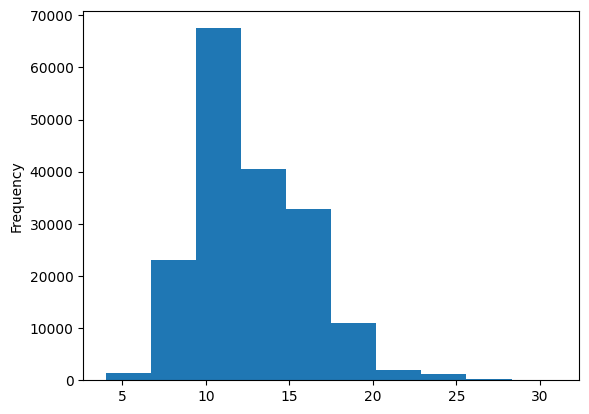

In [12]:
train_df.total_lines.plot.hist()

In [13]:
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)


(180040, 30212, 30135)

In [14]:
train_sentences[:10]

['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .',
 'Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP ) were measured .',
 'There was a clinic

## Make numeric labels (ML models require numeric labels)

In [15]:
from sklearn.preprocessing import OneHotEncoder

# Assuming you have a DataFrame with a 'target' column
encoder = OneHotEncoder(sparse=False)

# Reshape the target column to a 2D array
train_labels_reshaped = train_df['target'].values.reshape(-1, 1)
val_labels_reshaped = val_df['target'].values.reshape(-1, 1)
test_labels_reshaped = test_df['target'].values.reshape(-1, 1)

# Fit and transform the target column
train_labels_one_hot = encoder.fit_transform(train_labels_reshaped)
val_labels_one_hot = encoder.transform(val_labels_reshaped)
test_labels_one_hot = encoder.transform(test_labels_reshaped)

# Check the shapes
print("Train labels shape:", train_labels_one_hot.shape)
print("Validation labels shape:", val_labels_one_hot.shape)
print("Test labels shape:", test_labels_one_hot.shape)

# Print the first 10 rows of train_labels
print("Train labels (first 10 rows):")
print(train_labels_one_hot[:10])


Train labels shape: (180040, 5)
Validation labels shape: (30212, 5)
Test labels shape: (30135, 5)
Train labels (first 10 rows):
[[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [16]:
# prompt: do the same as above, but use labelencoder

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoder = label_encoder.fit_transform(train_df['target'])
val_labels_encoder = label_encoder.transform(val_df['target'])
test_labels_encoder = label_encoder.transform(test_df['target'])
test_labels_encoder

array([0, 4, 4, ..., 4, 4, 1])

In [17]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Creating a series of model experiments

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report


# Create a pipeline with CountVectorizer and Multinomial Naive Bayes
model_0 = Pipeline([
    ('vectorizer', CountVectorizer()),  # Convert text to a bag-of-words representation
    ('classifier', MultinomialNB())      # Use Naive Bayes as the classifier
])

# Fit the model
model_0.fit(train_sentences, train_labels_encoder)



Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', MultinomialNB())])

In [19]:

# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoder)

0.765126439825235

In [20]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([0, 1, 3, ..., 4, 4, 0])

In [21]:
from helper_functions import calculate_results
baseline_results = calculate_results(
    y_true=val_labels_encoder,
    y_pred=baseline_preds
)
baseline_results

{'accuracy': 76.5126439825235,
 'precision': 0.7650764505306027,
 'recall': 0.765126439825235,
 'f1': 0.7649496950235074}

## Preparing our data for deep sequence models

In [22]:
from tensorflow.keras import layers



In [23]:
# prompt: check how long is each train_Sentences on average

train_sentences_lengths = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = sum(train_sentences_lengths) / len(train_sentences_lengths)
print(f"Average length of train sentences: {avg_sent_len}")


Average length of train sentences: 26.338269273494777


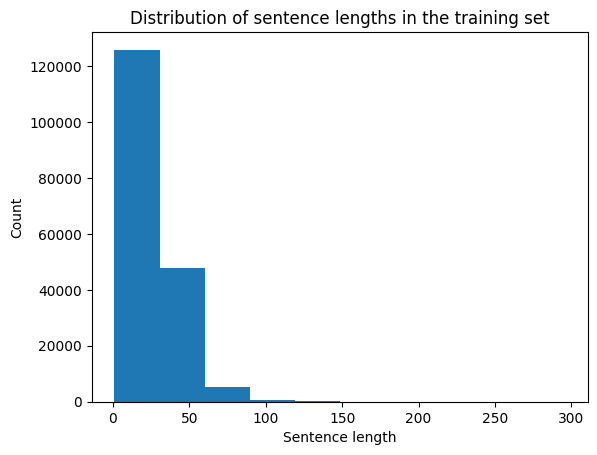

In [24]:
# prompt: check the distribution of sentece lengths

plt.hist(train_sentences_lengths)
plt.xlabel("Sentence length")
plt.ylabel("Count")
plt.title("Distribution of sentence lengths in the training set")
plt.show()


In [25]:
# prompt:  use NumPy's percentile to find the value which covers 95% of the sentence lengths.

import numpy as np
output_seq_len = int(np.percentile(train_sentences_lengths, 95))
output_seq_len

55

In [26]:
train_sentences[:3]

['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .']

In [27]:
train_sentences_lengths[:3]

[49, 27, 15]

In [28]:
[sentence.split() for sentence in train_sentences][:3]

[['To',
  'investigate',
  'the',
  'efficacy',
  'of',
  '@',
  'weeks',
  'of',
  'daily',
  'low-dose',
  'oral',
  'prednisolone',
  'in',
  'improving',
  'pain',
  ',',
  'mobility',
  ',',
  'and',
  'systemic',
  'low-grade',
  'inflammation',
  'in',
  'the',
  'short',
  'term',
  'and',
  'whether',
  'the',
  'effect',
  'would',
  'be',
  'sustained',
  'at',
  '@',
  'weeks',
  'in',
  'older',
  'adults',
  'with',
  'moderate',
  'to',
  'severe',
  'knee',
  'osteoarthritis',
  '(',
  'OA',
  ')',
  '.'],
 ['A',
  'total',
  'of',
  '@',
  'patients',
  'with',
  'primary',
  'knee',
  'OA',
  'were',
  'randomized',
  '@:@',
  ';',
  '@',
  'received',
  '@',
  'mg/day',
  'of',
  'prednisolone',
  'and',
  '@',
  'received',
  'placebo',
  'for',
  '@',
  'weeks',
  '.'],
 ['Outcome',
  'measures',
  'included',
  'pain',
  'reduction',
  'and',
  'improvement',
  'in',
  'function',
  'scores',
  'and',
  'systemic',
  'inflammation',
  'markers',
  '.']]

## Create text vectorizer

In [29]:
max_tokens = 68000


In [30]:
# prompt: create a text vectorizer using TextVectorization from tensorflow

text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=output_seq_len
)
text_vectorizer.adapt(train_sentences)

In [31]:
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")


Text:
Model-estimated probability of meeting physical-activity guidelines was @ % in the health-promotion intervention and @ % in attention-matched control ( OR = @ ; @ % CI , @-@ @ ) , adjusting for baseline prevalence and clustering from @ neighborhoods .

Length of text: 42

Vectorized text:
[[52148  1641     4  2314 29317   979    10     5     2 20526    38     3
      5 19141    35    16    50  1515    11    49   650     3  3827    27
  11495     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [32]:
# prompt: How many words in our training vocabulary?\

rct_20k_text_vocab = text_vectorizer.get_vocabulary()

rct_20k_text_vocab[-5:], rct_20k_text_vocab[:5]

(['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp'],
 ['', '[UNK]', 'the', 'and', 'of'])

In [33]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

## Create custom text embedding

In [34]:
# prompt: Create token embedding layer

embedding_dimension = 128

token_embed = tf.keras.layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dimension,
    embeddings_initializer='uniform',
    mask_zero=True,
    trainable=True
)


In [35]:
# prompt: Showm embedding example with random sentence

example_sentence = random.choice(train_sentences)
print(f"Example sentence: {example_sentence}")
example_sentence_vectors = text_vectorizer([example_sentence])
print(f"\nExample sentence vectors: {example_sentence_vectors}")
example_sentence_embeddings = token_embed(example_sentence_vectors)
print(f"\nExample sentence embeddings: {example_sentence_embeddings}")


Example sentence: The primary aim of this study will be to assess the effectiveness of the laryngeal mask airway over the face mask in preventing the need for endotracheal intubation .

Example sentence vectors: [[   2   56  267    4   23   17   95   36    6  216    2  257    4    2
  2924 2184  840  145    2 2388 2184    5 1126    2  483   11 2867  847
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Example sentence embeddings: [[[-0.03692     0.03356013  0.00511962 ... -0.0330158   0.02255425
   -0.02552018]
  [ 0.00232992  0.01023203 -0.02413172 ... -0.03463336  0.03022391
   -0.03715141]
  [ 0.04998131  0.00705097  0.04120655 ... -0.00884801 -0.02522708
    0.02786369]
  ...
  [ 0.03945413 -0.03297129  0.04460836 ...  0.00314013  0.04178018
    0.02082184]
  [ 0.03945413 -0.03297129  0.04460836 ...  0.00314013  0.04178018
    0.02082184]
  [ 0.03945413 -0.03297129  0.04460836 ...  0.003140

In [36]:
# prompt: create datasets using tf.data from tensorflow with prefecth and batch
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
train_dataset = train_dataset.shuffle(buffer_size=1024)
train_dataset = train_dataset.batch(batch_size=batch_size)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
val_dataset = val_dataset.batch(batch_size=batch_size)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
test_dataset = test_dataset.batch(batch_size=batch_size)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


## Model 1: Conv1D with token embeddings

In [37]:
# prompt: Create 1D convolutional model to process sequences with functiona API

inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)


In [38]:
# Get summary of Conv1D model
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 55, 128)           8704000   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 5)                 325   

In [39]:
model_1_history = model_1.fit(
    train_dataset,
    steps_per_epoch=int(0.1*len(train_dataset)),
    epochs=5,
    validation_data=val_dataset,
    validation_steps=int(0.1*len(val_dataset))
)


Epoch 1/5
562/562 [==============================] - 19s 29ms/step - loss: 0.8913 - accuracy: 0.6403 - val_loss: 0.6963 - val_accuracy: 0.7271
Epoch 2/5
562/562 [==============================] - 6s 11ms/step - loss: 0.6423 - accuracy: 0.7647 - val_loss: 0.6115 - val_accuracy: 0.7676
Epoch 3/5
562/562 [==============================] - 4s 8ms/step - loss: 0.6096 - accuracy: 0.7799 - val_loss: 0.5923 - val_accuracy: 0.7769
Epoch 4/5
562/562 [==============================] - 5s 9ms/step - loss: 0.5822 - accuracy: 0.7903 - val_loss: 0.5716 - val_accuracy: 0.7849
Epoch 5/5
562/562 [==============================] - 4s 8ms/step - loss: 0.5894 - accuracy: 0.7868 - val_loss: 0.5689 - val_accuracy: 0.7902


In [40]:
# prompt: evaluate model and make predicitons

model_1.evaluate(val_dataset)




945/945 [==============================] - 5s 5ms/step - loss: 0.5643 - accuracy: 0.7982


[0.5642679333686829, 0.798159658908844]

In [41]:
model_1_probs =  model_1.predict(val_dataset)
model_1_probs

945/945 [==============================] - 3s 3ms/step


array([[4.8408699e-01, 2.0576975e-01, 7.1971387e-02, 1.3828592e-01,
        9.9885993e-02],
       [3.6197621e-01, 4.5410597e-01, 1.4998922e-02, 9.2296362e-02,
        7.6622546e-02],
       [1.4207308e-01, 8.2688313e-03, 2.2439756e-03, 8.4734988e-01,
        6.4272055e-05],
       ...,
       [1.6351902e-05, 4.6762684e-04, 4.9433555e-03, 2.6650976e-05,
        9.9454606e-01],
       [9.2793174e-02, 2.5271901e-01, 1.3171986e-01, 2.9580709e-02,
        4.9318725e-01],
       [7.9980157e-02, 8.4511483e-01, 5.3004488e-02, 2.5813151e-03,
        1.9319192e-02]], dtype=float32)

In [42]:
model_1_preds = tf.argmax(model_1_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [43]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoder,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 79.81596716536475,
 'precision': 0.7937253918481812,
 'recall': 0.7981596716536475,
 'f1': 0.7938942151698593}

## Model 2: Feature extraction with pretrained token embeddings

In [44]:
import tensorflow_hub  as hub

tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                     trainable=False,
                                     name='universal_sentence_encoder')


In [45]:
_# prompt: test tf_hub_embedding_layer  with random sentecens

sentences = ['The quick brown fox jumps over the lazy dog',
             'The cow jumped over the moon',
             'The man ate the apple',
             'The dog chased the cat',
             'The bird flew across the sky']

# Convert sentences to vectors
sentence_vectors = tf_hub_embedding_layer(sentences)
sentence_vectors


<tf.Tensor: shape=(5, 512), dtype=float32, numpy=
array([[-0.03133016, -0.06338634, -0.01607502, ..., -0.03242781,
        -0.0457574 ,  0.05370456],
       [-0.0358599 , -0.0085492 , -0.01949548, ..., -0.03503276,
        -0.02458061, -0.01660721],
       [-0.0393524 , -0.00093045, -0.01300262, ..., -0.01198967,
         0.03388174, -0.05399775],
       [-0.00519574,  0.01867533,  0.05785012, ...,  0.01643884,
         0.0637878 ,  0.04247545],
       [-0.04715706,  0.05727269,  0.06124469, ...,  0.01410193,
        -0.01786573,  0.02743582]], dtype=float32)>

In [46]:
# prompt: build a model 2 with tf_hub_embedding_layer as a functional strucure


inputs = layers.Input(shape=[], dtype=tf.string)
x = tf_hub_embedding_layer(inputs)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_2 = tf.keras.Model(inputs, outputs)


In [47]:
# prompt: compile and fit molde 2

model_2.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

model_2_history = model_2.fit(
    train_dataset,
    steps_per_epoch=int(0.1*len(train_dataset)),
    epochs=5,
    validation_data=val_dataset,
    validation_steps=int(0.1*len(val_dataset))
)


Epoch 1/5
562/562 [==============================] - 10s 13ms/step - loss: 0.9489 - accuracy: 0.6381 - val_loss: 0.8058 - val_accuracy: 0.6862
Epoch 2/5
562/562 [==============================] - 8s 14ms/step - loss: 0.7792 - accuracy: 0.6959 - val_loss: 0.7633 - val_accuracy: 0.7038
Epoch 3/5
562/562 [==============================] - 7s 13ms/step - loss: 0.7685 - accuracy: 0.7051 - val_loss: 0.7522 - val_accuracy: 0.7101
Epoch 4/5
562/562 [==============================] - 7s 13ms/step - loss: 0.7345 - accuracy: 0.7193 - val_loss: 0.7337 - val_accuracy: 0.7164
Epoch 5/5
562/562 [==============================] - 8s 15ms/step - loss: 0.7508 - accuracy: 0.7115 - val_loss: 0.7166 - val_accuracy: 0.7231


In [48]:
# prompt: evaluate and make predictions with model 2

model_2.evaluate(val_dataset)



model_2_probs = model_2.predict(val_dataset)
model_2_probs
model_2_preds = tf.argmax(model_2_probs, axis=1)
model_2_preds
# Calculate model_2 results
model_2_results = calculate_results(y_true=val_labels_encoder,
                                    y_pred=model_2_preds)
model_2_results


945/945 [==============================] - 10s 10ms/step


{'accuracy': 72.53078247054151,
 'precision': 0.7237037608570566,
 'recall': 0.7253078247054151,
 'f1': 0.7216517188057064}

## Model 3: Conv1D with character embeddings

In [49]:
# prompt: Make function to split sentences into characters vand join them with a space

def sentence_to_characters(sentence):
  """
  Split a sentence into characters and join them with a space.
  This is to make the sentence compatible with the character embedding layer.
  """
  return ' '.join(list(sentence))


sentence_to_characters(target_sentence)

'M o d e l - e s t i m a t e d   p r o b a b i l i t y   o f   m e e t i n g   p h y s i c a l - a c t i v i t y   g u i d e l i n e s   w a s   @   %   i n   t h e   h e a l t h - p r o m o t i o n   i n t e r v e n t i o n   a n d   @   %   i n   a t t e n t i o n - m a t c h e d   c o n t r o l   (   O R   =   @   ;   @   %   C I   ,   @ - @   @   )   ,   a d j u s t i n g   f o r   b a s e l i n e   p r e v a l e n c e   a n d   c l u s t e r i n g   f r o m   @   n e i g h b o r h o o d s   .'

In [50]:
# prompt: split sequence level data splits into character level data splits

train_sentences_characters = [sentence_to_characters(sentence) for sentence in train_sentences]
val_sentences_characters = [sentence_to_characters(sentence) for sentence in val_sentences]
test_sentences_characters = [sentence_to_characters(sentence) for sentence in test_sentences]


In [51]:
test_sentences_characters[1]

'A   p o s t   h o c   a n a l y s i s   w a s   c o n d u c t e d   w i t h   t h e   u s e   o f   d a t a   f r o m   t h e   E v a l u a t i o n   S t u d y   o f   C o n g e s t i v e   H e a r t   F a i l u r e   a n d   P u l m o n a r y   A r t e r y   C a t h e t e r i z a t i o n   E f f e c t i v e n e s s   (   E S C A P E   )   .'

In [52]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

In [53]:
char_lens[:3]

[281, 137, 111]

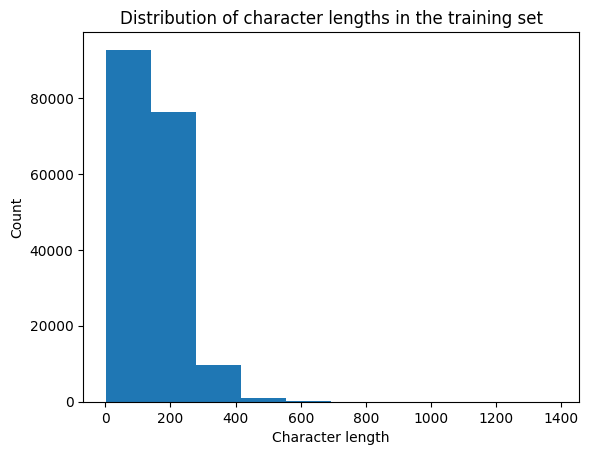

In [54]:
# prompt: check the distibution of our sequences at character level

plt.hist(char_lens)
plt.xlabel("Character length")
plt.ylabel("Count")
plt.title("Distribution of character lengths in the training set")
plt.show()


In [55]:
# prompt: get the 95 percent

output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [56]:
# prompt: Get all keyboard characters for char-level embedding

import string
all_characters = list(string.ascii_lowercase + string.punctuation +string.digits + ' ')
all_characters

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [57]:
NUM_CHAR_TOKENS = len(all_characters) + 1
char_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=NUM_CHAR_TOKENS,
    output_sequence_length=output_seq_char_len,
    standardize='lower_and_strip_punctuation',
    name='char_vectorizer'
)

char_vectorizer.adapt(train_sentences_characters)

In [58]:
# prompt: Check character vocabulary characteristics

char_vocab = char_vectorizer.get_vocabulary()
char_vocab[:5], char_vocab[-5:]

(['', '[UNK]', 'e', 't', 'i'], ['k', 'x', 'z', 'q', 'j'])

In [59]:
# prompt: test a random senteces

random_sentence = random.choice(train_sentences)
print(f"Example sentence: {random_sentence}")
example_sentence_characters = sentence_to_characters(random_sentence)
print(f"\nExample sentence characters: {example_sentence_characters}")
example_sentence_char_vectors = char_vectorizer(example_sentence_characters)
print(f"\nExample sentence character vectors: {example_sentence_char_vectors}")


Example sentence: We recommend the use of PCN tube if the stone size is > @cm , as there was a greater risk of possible iatrogenic ureteric injury during stenting with these larger ureteric stones in addition to prolongation of operative time with an increased incidence of failure .

Example sentence characters: W e   r e c o m m e n d   t h e   u s e   o f   P C N   t u b e   i f   t h e   s t o n e   s i z e   i s   >   @ c m   ,   a s   t h e r e   w a s   a   g r e a t e r   r i s k   o f   p o s s i b l e   i a t r o g e n i c   u r e t e r i c   i n j u r y   d u r i n g   s t e n t i n g   w i t h   t h e s e   l a r g e r   u r e t e r i c   s t o n e s   i n   a d d i t i o n   t o   p r o l o n g a t i o n   o f   o p e r a t i v e   t i m e   w i t h   a n   i n c r e a s e d   i n c i d e n c e   o f   f a i l u r e   .

Example sentence character vectors: [20  2  8  2 11  7 15 15  2  6 10  3 13  2 16  9  2  7 17 14 11  6  3 16
 22  2  4 17  3 13  2  9  3  7  6  2  9  4 25 

## Creating a character-level embedding


In [60]:
# prompt: create a character level embedding

char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS,
                                output_dim=25,
                              mask_zero=True,
                                name='char_embed')


In [61]:
# prompt: test out char_embed with a random sentence and use prints to see each stage

random_sentence = random.choice(train_sentences)
print(f"Example sentence: {random_sentence}")
example_sentence_characters = sentence_to_characters(random_sentence)
print(f"\nExample sentence characters: {example_sentence_characters}")
example_sentence_char_vectors = char_vectorizer(example_sentence_characters)
print(f"\nExample sentence character vectors: {example_sentence_char_vectors}")
example_char_embed_output = char_embed(example_sentence_char_vectors)
print(f"\nExample sentence character embedding output: {example_char_embed_output}")
example_char_embed_output.shape

Example sentence: In this randomized trial of patients with Barrett esophagus and a confirmed diagnosis of low-grade dysplasia , radiofrequency ablation resulted in a reduced risk of neoplastic progression over @ years of follow-up .

Example sentence characters: I n   t h i s   r a n d o m i z e d   t r i a l   o f   p a t i e n t s   w i t h   B a r r e t t   e s o p h a g u s   a n d   a   c o n f i r m e d   d i a g n o s i s   o f   l o w - g r a d e   d y s p l a s i a   ,   r a d i o f r e q u e n c y   a b l a t i o n   r e s u l t e d   i n   a   r e d u c e d   r i s k   o f   n e o p l a s t i c   p r o g r e s s i o n   o v e r   @   y e a r s   o f   f o l l o w - u p   .

Example sentence character vectors: [ 4  6  3 13  4  9  8  5  6 10  7 15  4 25  2 10  3  8  4  5 12  7 17 14
  5  3  4  2  6  3  9 20  4  3 13 22  5  8  8  2  3  3  2  9  7 14 13  5
 18 16  9  5  6 10  5 11  7  6 17  4  8 15  2 10 10  4  5 18  6  7  9  4
  9  7 17 12  7 20 18  8  5 10  2 10 19  9 14 12  

TensorShape([290, 25])

## Building a Conv1D model to fit on character embeddings


In [62]:
# prompt: make a conv1d model only using chars

inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same')(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_3 = tf.keras.Model(inputs, outputs)

model_3.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

model_3.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 5)                 325 

In [63]:
# prompt: now create a character level batched and prefetched dataset using tf.Data

char_batch = 32
train_char_dataset  = tf.data.Dataset.from_tensor_slices((train_sentences_characters, train_labels_one_hot))
train_char_dataset  = train_char_dataset.shuffle(buffer_size=1024).batch(char_batch).prefetch(tf.data.AUTOTUNE)

val_char_dataset = tf.data.Dataset.from_tensor_slices((val_sentences_characters, val_labels_one_hot))
val_char_dataset = val_char_dataset.batch(char_batch).prefetch(tf.data.AUTOTUNE)

test_char_dataset = tf.data.Dataset.from_tensor_slices((test_sentences_characters, test_labels_one_hot))
test_char_dataset = test_char_dataset.batch(char_batch).prefetch(tf.data.AUTOTUNE)


In [64]:
model_3_history = model_3.fit(
    train_char_dataset,
    steps_per_epoch=int(0.1*len(train_char_dataset)),
    epochs=5,
    validation_data=val_char_dataset,
    validation_steps=int(0.1*len(val_char_dataset))
)


Epoch 1/5
562/562 [==============================] - 4s 6ms/step - loss: 1.2449 - accuracy: 0.4921 - val_loss: 1.0259 - val_accuracy: 0.5851
Epoch 2/5
562/562 [==============================] - 3s 5ms/step - loss: 0.9962 - accuracy: 0.5998 - val_loss: 0.9159 - val_accuracy: 0.6463
Epoch 3/5
562/562 [==============================] - 4s 7ms/step - loss: 0.9102 - accuracy: 0.6423 - val_loss: 0.8699 - val_accuracy: 0.6579
Epoch 4/5
562/562 [==============================] - 3s 5ms/step - loss: 0.8602 - accuracy: 0.6668 - val_loss: 0.8302 - val_accuracy: 0.6799
Epoch 5/5
562/562 [==============================] - 3s 5ms/step - loss: 0.8509 - accuracy: 0.6670 - val_loss: 0.8067 - val_accuracy: 0.6868


In [65]:
model_3.evaluate(val_char_dataset)


945/945 [==============================] - 3s 4ms/step - loss: 0.8277 - accuracy: 0.6777


[0.8277420401573181, 0.6776777505874634]

In [66]:

model_3_probs = model_3.predict(val_char_dataset)
model_3_probs
model_3_preds = tf.argmax(model_3_probs, axis=1)
model_3_preds
# Calculate model_3 results
model_3_results = calculate_results(y_true=val_labels_encoder,
                                    y_pred=model_3_preds)
model_3_results

945/945 [==============================] - 2s 3ms/step


{'accuracy': 67.76777439428042,
 'precision': 0.6725430708703979,
 'recall': 0.6776777439428042,
 'f1': 0.6709031100156964}

## Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

In [67]:
#1. Set up token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

#2. Set up char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)

char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

from tensorflow.keras import layers

# Assuming token_output and char_bi_lstm are your input layers or tensors
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output, char_model.output])

#4. Create output layers
combine_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation='relu')(combine_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

#5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name='model_4_token_and_char_embedding')


In [68]:
model_4.summary()

Model: "model_4_token_and_char_embedding"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978  

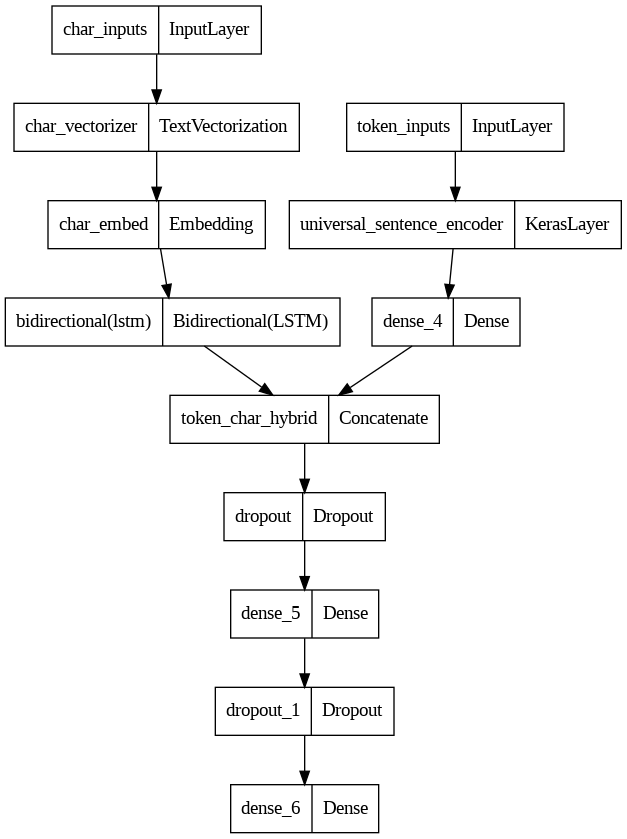

In [69]:
# Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4)

In [70]:
# prompt: compile model 4

model_4.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)


In [71]:

# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_sentences_characters)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels



# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32)

In [72]:
# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_sentences_characters))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [73]:

# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_BatchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [74]:
# prompt: fit model 4

history_4 = model_4.fit(
    train_char_token_dataset,
    steps_per_epoch=int(0.1*len(train_char_token_dataset)),
    epochs=5,
    validation_data=val_char_token_dataset,
    validation_steps=int(0.1*len(val_char_token_dataset))
)


Epoch 1/5
562/562 [==============================] - 41s 53ms/step - loss: 0.9594 - accuracy: 0.6179 - val_loss: 0.7709 - val_accuracy: 0.7031
Epoch 2/5
562/562 [==============================] - 27s 48ms/step - loss: 0.7874 - accuracy: 0.6945 - val_loss: 0.7092 - val_accuracy: 0.7284
Epoch 3/5
562/562 [==============================] - 25s 44ms/step - loss: 0.7620 - accuracy: 0.7104 - val_loss: 0.6850 - val_accuracy: 0.7360
Epoch 4/5
562/562 [==============================] - 28s 50ms/step - loss: 0.7340 - accuracy: 0.7239 - val_loss: 0.6633 - val_accuracy: 0.7550
Epoch 5/5
562/562 [==============================] - 25s 45ms/step - loss: 0.7375 - accuracy: 0.7183 - val_loss: 0.6433 - val_accuracy: 0.7573


In [75]:
# prompt: evaluate and make predictions with model 4

model_4.evaluate(val_char_token_dataset)



945/945 [==============================] - 19s 20ms/step - loss: 0.6516 - accuracy: 0.7513


[0.6515534520149231, 0.7512908577919006]

In [76]:
model_4_probs = model_4.predict(val_char_token_dataset)
model_4_preds = tf.argmax(model_4_probs, axis=1)
model_4_results = calculate_results(y_true=val_labels_encoder,
                                    y_pred=model_4_preds)
model_4_results

945/945 [==============================] - 22s 19ms/step


{'accuracy': 75.12908777969018,
 'precision': 0.7474889402028483,
 'recall': 0.7512908777969018,
 'f1': 0.7470376490750633}

## Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

In [77]:
train_df.head()

,line_number,target,text,total_lines
0,1,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,12
1,2,METHODS,A total of @ patients with primary knee OA wer...,12
2,3,METHODS,Outcome measures included pain reduction and i...,12
3,4,METHODS,Pain was assessed using the visual analog pain...,12
4,5,METHODS,Secondary outcome measures included the Wester...,12


In [78]:
train_df["line_number"].value_counts()

1     15000
2     15000
3     15000
4     15000
5     14992
6     14949
7     14758
8     14279
9     13346
10    11981
11    10041
12     7892
13     5853
14     4152
15     2835
16     1861
17     1188
18      751
19      462
20      286
21      162
22      101
23       66
24       33
25       22
26       14
27        7
28        4
29        3
30        1
31        1
Name: line_number, dtype: int64

In [79]:
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)


In [80]:
train_line_numbers_one_hot

<tf.Tensor: shape=(180040, 15), dtype=float32, numpy=
array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)>

In [81]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]


(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

## Building a tribrid embedding model


In [87]:
# Token inputs
token_inputs = layers.Input(shape=[], dtype='string', name='token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_embeddings)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype='string', name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. Line number inputs
line_number_inputs = layers.Input(shape=(15), dtype=tf.int32, name='line_number_inputs')
x = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs, outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name='total_lines_inputs')
y = layers.Dense(32, activation = 'relu')(total_lines_inputs)
total_line_model = tf.keras.Model(total_lines_inputs, y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name='token_char_hybrid')([
    token_model.output,
    char_model.output
])

z = layers.Dense(256, activation='relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char models
z = layers.Concatenate(name='token_char_positional_embedding')([
    line_number_model.output,
    total_line_model.output,
    z
])

# 7. Create output layers
output_layer = layers.Dense(5, activation='softmax', name='output_layer')(z)


# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)


In [88]:
model_5.summary()


Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_embed (Embedding)      (None, 290, 25)              1750      ['char_vectorizer[7][0]

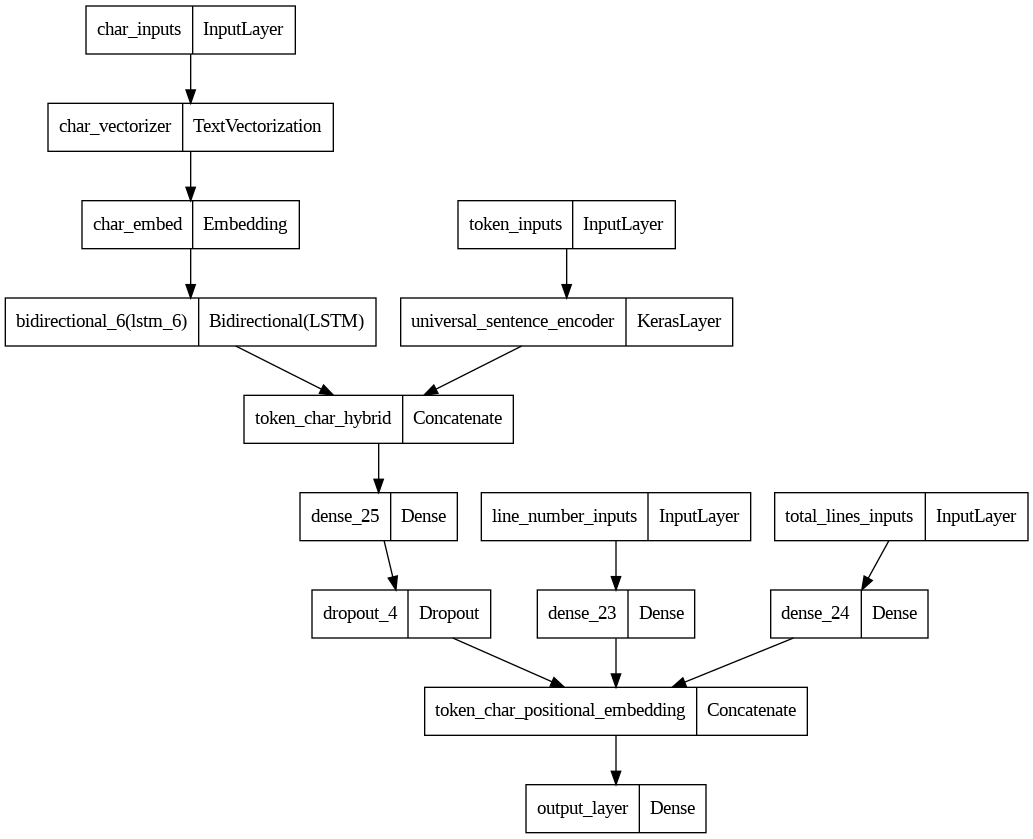

In [89]:
# Plot the token, char, positional embedding model
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [100]:
# Compile token, char, positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [99]:

# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_sentences_characters)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_sentences_characters))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [101]:
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [103]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=5,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))


Epoch 1/5
562/562 [==============================] - 30s 53ms/step - loss: 1.0091 - accuracy: 0.7917 - val_loss: 0.9734 - val_accuracy: 0.8122
Epoch 2/5
562/562 [==============================] - 29s 52ms/step - loss: 0.9673 - accuracy: 0.8164 - val_loss: 0.9501 - val_accuracy: 0.8285
Epoch 3/5
562/562 [==============================] - 24s 43ms/step - loss: 0.9543 - accuracy: 0.8227 - val_loss: 0.9440 - val_accuracy: 0.8351
Epoch 4/5
562/562 [==============================] - 28s 50ms/step - loss: 0.9466 - accuracy: 0.8329 - val_loss: 0.9376 - val_accuracy: 0.8281
Epoch 5/5
562/562 [==============================] - 26s 46ms/step - loss: 0.9438 - accuracy: 0.8330 - val_loss: 0.9317 - val_accuracy: 0.8398


In [106]:
# prompt: evaluate and predict with model 5

history_model_5.history
# Evaluate the model on the test set
model_5.evaluate(val_pos_char_token_dataset)



945/945 [==============================] - 20s 21ms/step - loss: 0.9289 - accuracy: 0.8397


[0.9289374351501465, 0.8397325277328491]

In [108]:
# Make predictions on the test set
model_5_probs = model_5.predict(val_pos_char_token_dataset)



945/945 [==============================] - 21s 23ms/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

In [109]:
model_5_preds = tf.argmax(model_5_probs, axis=1)
model_5_preds

model_5_results = calculate_results(
    val_labels_encoder,
    model_5_preds
)

In [110]:
model_5_results

{'accuracy': 83.97325566000265,
 'precision': 0.8427231461245152,
 'recall': 0.8397325566000264,
 'f1': 0.8351055022620955}

## Compare model results

In [115]:
# prompt: # Combine model resuls from variable calculate_results for each model into a dataframe

models = ['baseline_model',"Model 1", "Model 2", "Model 3", "Model 4", "Model 5"]
results = [baseline_results,model_1_results, model_2_results, model_3_results, model_4_results, model_5_results]
all_model_results = pd.DataFrame(results, index=models)
all_model_results.index.name = "Model"
all_model_results.columns = ["Accuracy", "F1 Score", "Precision", "Recall"]
all_model_results['Accuracy'] = all_model_results['Accuracy'] / 100
all_model_results

,Accuracy,F1 Score,Precision,Recall
Model,,,,
baseline_model,0.765126,0.765076,0.765126,0.764950
Model 1,0.798160,0.793725,0.798160,0.793894
Model 2,0.725308,0.723704,0.725308,0.721652
Model 3,0.677678,0.672543,0.677678,0.670903
Model 4,0.751291,0.747489,0.751291,0.747038
Model 5,0.839733,0.842723,0.839733,0.835106


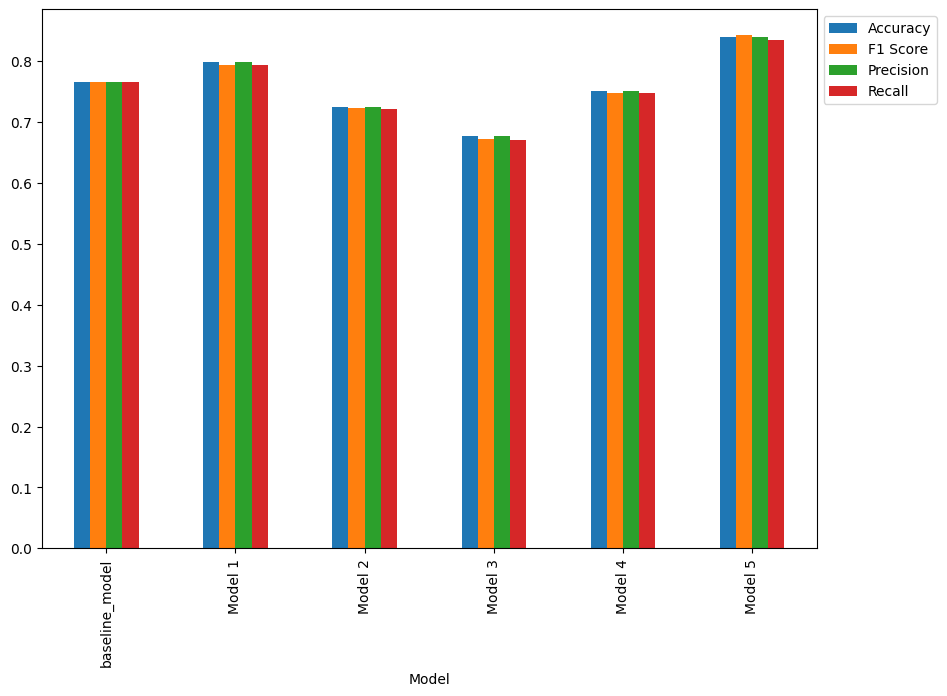

In [116]:
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));


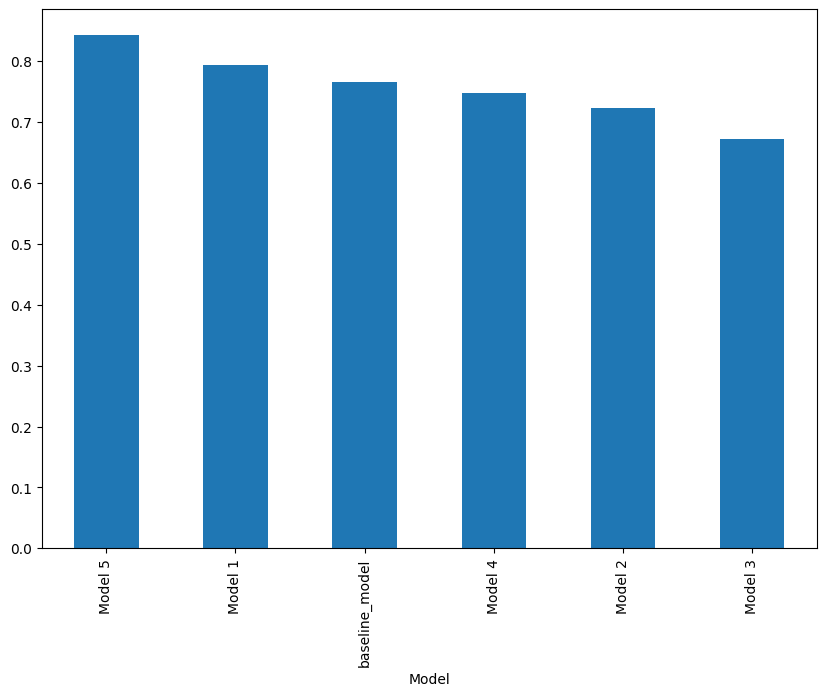

In [118]:
all_model_results.sort_values("F1 Score", ascending=False)["F1 Score"].plot(kind="bar", figsize=(10, 7));


## Save and load best perfrmoing model

In [119]:
model_5.save('skimlit_tribrid_model')

## Test model 5

In [120]:
# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_sentences_characters))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [122]:
test_pred_probs = model_5.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 21s 22ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 4, 4, 1, 1, 0])>